# Monet Painter

## Problem Statement

The goal of this project is to use generative adversarial networks (GANs) to create 7,000 to 10,000 images in the style of Claude Monet. The GAN will consist of a generator that produces Monet-style images and a discriminator that distinguishes between real and generated images. The challenge is to train these models to generate high-quality images that convincingly replicate Monet's artistic style.

## Data Preprocessing and EDA

### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import warnings

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Suppress Python warnings
warnings.filterwarnings("ignore")

2024-06-13 15:21:37.720423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 15:21:37.720532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 15:21:37.851450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Set the consistant values and the hyper parameters

In [ ]:
# The size of the buffer used for shuffling the dataset
BUFFER_SIZE = 1000

# The number of images in each batch
BATCH_SIZE = 1

# The number of times the entire dataset will be passed through the model during training
EPOCHS = 64

# The weight for the L1 loss term in the generator loss function
LAMBDA = 10

# The width of the input images
IMG_WIDTH = 256

# The height of the input images
IMG_HEIGHT = 256

### Define functions to preprocess the data

In [ ]:
# Load the image
def load_image(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

# Preprocess the training image
def preprocess_train_image(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

# Preprocessing the testing image
def preprocess_test_image(image, label = None):
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  image = (image/ 127.5) -1
  return image

# Define a function to parse the TFRecord
def parse_tfrecord(tfrecord):
  feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_single_example(tfrecord, feature_description)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


### Load the dataset

In [ ]:
# Set the image root paths
monet_tfrec_path = "/kaggle/input/gan-getting-started/monet_tfrec/"
photo_jpg_path = "/kaggle/input/gan-getting-started/photo_jpg/"

# Get the image paths
monet_tfrec_files = sorted(tf.io.gfile.glob(monet_tfrec_path + "*.tfrec"))
photo_jpg_files = sorted(tf.io.gfile.glob(photo_jpg_path + "*.jpg"))

# Load the dataset
monet_tfrec_dataset = tf.data.TFRecordDataset(monet_tfrec_files)
monet_tfrec_dataset = monet_tfrec_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_jpg_files)
photo_dataset = photo_dataset.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# Apply preprocessing to datasets
monet_tfrec_dataset = monet_tfrec_dataset.map(lambda x: preprocess_train_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
photo_dataset = photo_dataset.map(lambda x: preprocess_train_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and get the batch of dataset
monet_tfrec_dataset = monet_tfrec_dataset.shuffle(BUFFER_SIZE)
monet_tfrec_dataset = monet_tfrec_dataset.batch(BATCH_SIZE, drop_remainder=True)
photo_dataset = photo_dataset.shuffle(BUFFER_SIZE)
photo_dataset = photo_dataset.batch(BATCH_SIZE, drop_remainder = True)

### Check the shape of the image

In [ ]:
# Check the shape of the first images
for image in monet_tfrec_dataset.take(1):
  print("Shape of Monet image:", image.shape)
for image in photo_dataset.take(1):
  print("Shape of Photo image:", image.shape)

Shape of Monet image: (1, 256, 256, 3)
Shape of Photo image: (1, 256, 256, 3)


### Show some images randomly to check their quality

Monet Images:


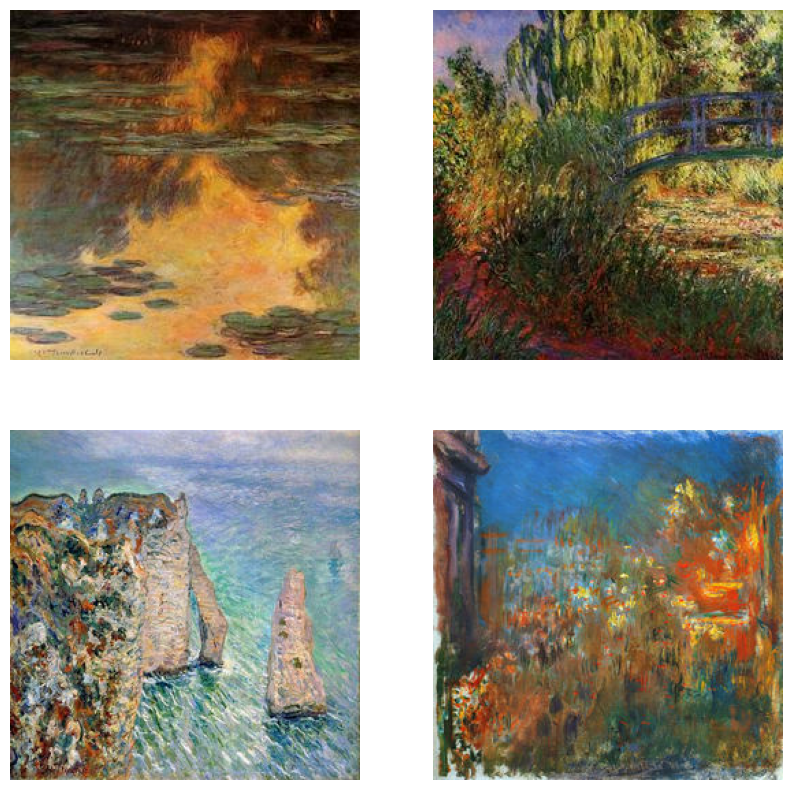

Photo Images:


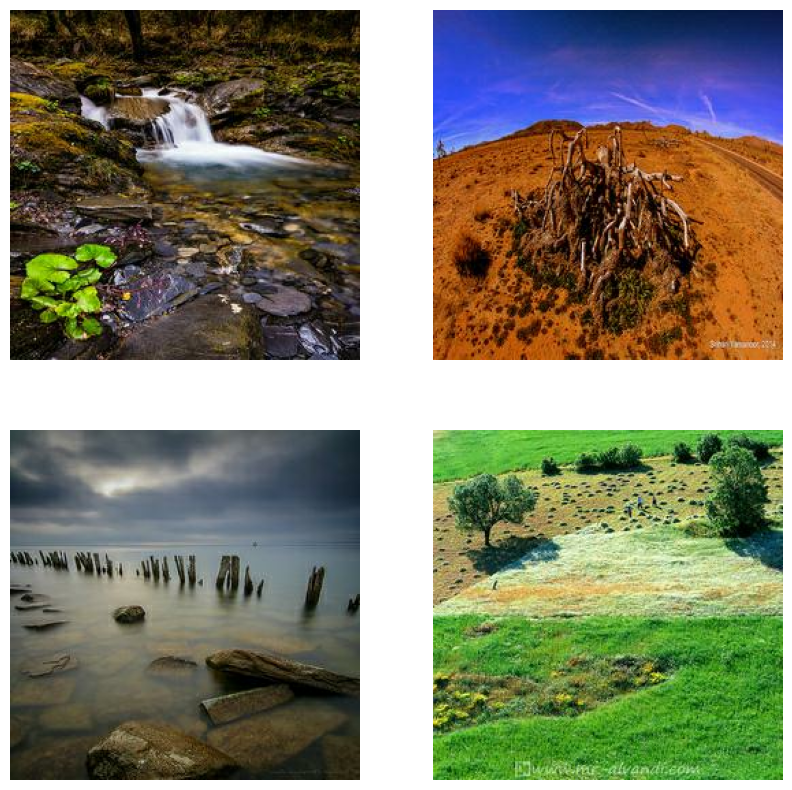

In [ ]:
# Print out the images after loading but before preprocessing
def print_loaded_images(dataset):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(4)):
        plt.subplot(2, 2, i + 1)
        image = tf.squeeze(image, axis=0)  # Remove the batch dimension
        # Print the minimum and maximum pixel values
        image = tf.cast(((image + 1) * 127.5), tf.uint8)  # Scale to [0, 255] and cast to uint8
        plt.imshow(image)
        plt.axis("off")
    plt.show()

# Print out images from both datasets
print("Monet Images:")
print_loaded_images(monet_tfrec_dataset)

print("Photo Images:")
print_loaded_images(photo_dataset)


The images look good, then we can prepare our models

## Model Creation

## Help functions for Generator and Discriminator models

In [ ]:
# Create a convolutional block for downsampling
def downsample(filters, size, apply_batchnorm = True):
  # Create a initializer for the weights of the convolutional layer, the 0. means the mean value, 0.02 is the standard divation
  initializer = tf.random_normal_initializer(0., 0.02)
  # Sequential model to stack layers sequentially
  result = tf.keras.Sequential()
  # Add a Conv2D layer with setting the parameters
  result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))

  # Add BatchNormalization layer if apply_batchnorm is True
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  # Add LeakyReLU activation function
  result.add(tf.keras.layers.LeakyReLU())

  # Return the downsampling block
  return result

# Create a transposed convolutional block for upsampling
def upsample(filters, size, apply_dropout = False):
  # Create a initializer for the weights of the transposed convolutional layer
  initializer = tf.random_normal_initializer(0., 0.02)
  # Sequential model to stack layers sequentially
  result = tf.keras.Sequential()
  # Add a Conv2DTranspose layer with setting the parameters
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))

  # Add a BachNormalization layer
  result.add(tf.keras.layers.BatchNormalization())

  # Add a Dropout layer with a rate of 0.1 if apply_dropout is True
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.1))

  # Add ReLU activation function
  result.add(tf.keras.layers.ReLU())

  # Return the upsampling block
  return result

### The Generators

In [ ]:
def Generator():
    # Create an input layer with shape (256,256,3)
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))

    # Downsampling layers
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]

    # Upsampling layers
    up_stack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4)
    ]

    # The last layer
    initializer = tf.keras.initializers.GlorotUniform()
    last = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same',
                                            kernel_initializer=initializer, activation='tanh')

    # Connect all the layers
    x = inputs

    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### The Criminators

In [ ]:
def Discriminator():
  initializer = tf.keras.initializers.GlorotUniform()
  # Create the input layers to get the input image data
  input = tf.keras.layers.Input(shape = (256, 256, 3))

  # downsample the input layer
  x = downsample(64, 4, False)(input)
  x = downsample(128, 4)(x)
  x = downsample(256, 4)(x)

  # Pad the feature maps
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(x)
  # Con2D on the feature maps after padding
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer = initializer, use_bias = False)(zero_pad1)

  # BatchNormalization
  norm1 = tf.keras.layers.BatchNormalization()(conv)

  # LeakyReLU as activition
  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  # Pad again
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  # Last layer
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer = initializer)(zero_pad2)

  # Return the model
  return tf.keras.Model(inputs = input, outputs = last)

### Loss functions

In [ ]:
# Define a Binary Crossentropy loss function object
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

# Define the discriminator loss function
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Define the generator loss function
def generator_loss(disc_generated_output, gen_output, cycled_output, same_output, real_output, real_image):
    # Adversarial loss
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Cycle consistency loss
    cycle_loss = tf.reduce_mean(tf.abs(real_output - cycled_output))

    # Identity loss
    identity_loss = tf.reduce_mean(tf.abs(real_image - same_output))

    # Total generator loss
    total_gen_loss = gan_loss + (LAMBDA * cycle_loss) + (0.5 * LAMBDA * identity_loss)
    return total_gen_loss

### Optimizer, Generator and Discriminator Instances

In [ ]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

# Generators
generator_g = Generator()
generator_f = Generator()

# Discriminators
discriminator_x = Discriminator()
discriminator_y = Discriminator()

### The training function for the models

In [ ]:
# Define a function to apply gradient clipping
def apply_gradient_clipping(grads, clip_value):
    clipped_grads = []
    for grad in grads:
        clipped_grads.append(tf.clip_by_value(grad, -clip_value, clip_value))
    return clipped_grads

In [ ]:
def train_step(real_x, real_y, clip_value=0.5):
    with tf.GradientTape(persistent=True) as tape:

        # Generate the fake image from x to y
        fake_y = generator_g(real_x, training=True)
        # Generate the fake image from y to x
        cycled_x = generator_f(fake_y, training=True)

        # Generate the fake image
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Generate the same image
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Get the discriminator output for real x and real y images
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        # Get the discriminator output for fake x and fake y images
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y, fake_y, cycled_x, same_y, real_x, real_y)
        gen_f_loss = generator_loss(disc_fake_x, fake_x, cycled_y, same_x, real_y, real_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Clip gradients
    clipped_generator_g_gradients = apply_gradient_clipping(generator_g_gradients, clip_value)
    clipped_generator_f_gradients = apply_gradient_clipping(generator_f_gradients, clip_value)
    clipped_discriminator_x_gradients = apply_gradient_clipping(discriminator_x_gradients, clip_value)
    clipped_discriminator_y_gradients = apply_gradient_clipping(discriminator_y_gradients, clip_value)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(clipped_generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(clipped_generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(clipped_discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(clipped_discriminator_y_gradients, discriminator_y.trainable_variables))

    return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss

### Train the models

### Function to visualize generated images

In [ ]:
# Function to generate and plot images using generator_g
def generate_images(generator, test_input):
    # Generate translated images
    generated_images = generator(test_input, training=False)

    # Plot the original and translated images
    fig = plt.figure(figsize=(10, 5))

    # Plot original images
    for i in range(test_input.shape[0]):
        plt.subplot(2, 3, i + 1)
        plt.imshow(test_input[i] * 0.5 + 0.5)  # Rescale to [0, 1]
        plt.axis('off')
        plt.title('Original')

    # Plot translated images
    for i in range(generated_images.shape[0]):
        plt.subplot(2, 3, i + 4)
        plt.imshow(generated_images[i] * 0.5 + 0.5)  # Rescale to [0, 1]
        plt.axis('off')
        plt.title('Generated')

    plt.show()

Epoch: 16
Generator G Loss: 3.9247, Generator F Loss: 3.9017
Discriminator X Loss: 1.2599, Discriminator Y Loss: 1.2687


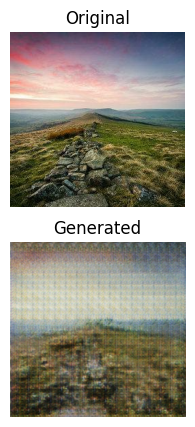

Epoch: 32
Generator G Loss: 3.7863, Generator F Loss: 3.7504
Discriminator X Loss: 1.1932, Discriminator Y Loss: 1.1598


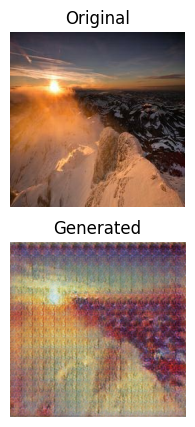

Epoch: 48
Generator G Loss: 3.7446, Generator F Loss: 3.7504
Discriminator X Loss: 1.1723, Discriminator Y Loss: 1.1612


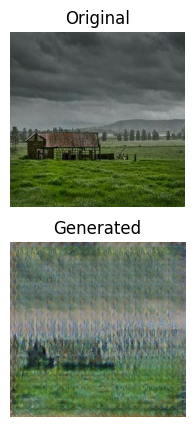

Epoch: 64
Generator G Loss: 3.8508, Generator F Loss: 3.8326
Discriminator X Loss: 1.0926, Discriminator Y Loss: 1.1144


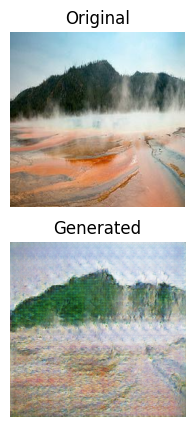

In [ ]:
# Train the model
for epoch in range(EPOCHS):

    total_gen_g_loss = 0
    total_gen_f_loss = 0
    total_disc_x_loss = 0
    total_disc_y_loss = 0
    num_batches = 0

    for real_x, real_y in tf.data.Dataset.zip((photo_dataset, monet_tfrec_dataset)):
        # Perform a training step and get the losses
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(real_x, real_y)

        # Accumulate the losses
        total_gen_g_loss += gen_g_loss
        total_gen_f_loss += gen_f_loss
        total_disc_x_loss += disc_x_loss
        total_disc_y_loss += disc_y_loss
        num_batches += 1

    # Calculate average losses
    avg_gen_g_loss = total_gen_g_loss / num_batches
    avg_gen_f_loss = total_gen_f_loss / num_batches
    avg_disc_x_loss = total_disc_x_loss / num_batches
    avg_disc_y_loss = total_disc_y_loss / num_batches

    if (epoch + 1) % 16 == 0:

        print("Epoch:", epoch + 1)

        # Print the average losses for the epoch
        print(f"Generator G Loss: {avg_gen_g_loss:.4f}, Generator F Loss: {avg_gen_f_loss:.4f}")
        print(f"Discriminator X Loss: {avg_disc_x_loss:.4f}, Discriminator Y Loss: {avg_disc_y_loss:.4f}")

        # Get the first image of the photo dataset
        test_input = next(iter(photo_dataset))
        # Visualize the specific image
        generate_images(generator_g, test_input)

# Save the models
generator_g.save('generator_g.h5')
generator_f.save('generator_f.h5')
discriminator_x.save('discriminator_x.h5')
discriminator_y.save('discriminator_y.h5')

## Generate the photos with Monet Style

### Generate and save the Monet style images

In [ ]:
# Ensure the load_image function loads images with the correct shape and color channels
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure 3 color channels
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Define a function to generate an image using the generator
def generate_image(generator, input_image):
    generated_image = generator(input_image, training=False)
    generated_image = (generated_image + 1) * 127.5  # Convert from [-1, 1] to [0, 255]
    generated_image = tf.cast(generated_image, tf.uint8)  # Convert to uint8 type
    return generated_image

# Define a function to save images to a zip file
def save_images(generator, dataset, zip_file_name, num_images=10000):
    zip_file_path = os.path.join('/kaggle/working', zip_file_name)
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for i, image_x in enumerate(dataset.take(num_images)):
            fake_y = generate_image(generator, image_x)
            for j in range(fake_y.shape[0]):
                image = fake_y[j].numpy()
                # Convert to JPEG byte array
                img_byte_arr = tf.io.encode_jpeg(image).numpy()
                # Write to zip file
                zipf.writestr(f'image_{i * fake_y.shape[0] + j}.jpg', img_byte_arr)

# Define a function to plot generated images
def plot_images(generator, dataset, title, num_images=4):
    plt.figure(figsize=(10, 10))
    for i, image_x in enumerate(dataset.take(num_images)):
        fake_y = generate_image(generator, image_x)
        for j in range(fake_y.shape[0]):
            plt.subplot(num_images // 2, 2, i * fake_y.shape[0] + j + 1)
            image = fake_y[j].numpy()
            plt.imshow(image)
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Generate and show some sample images
def generate_and_plot_images(generator, dataset, num_images=4):
    plot_images(generator, dataset, "Generated Images", num_images)

### Show four generated images to check their qualities.

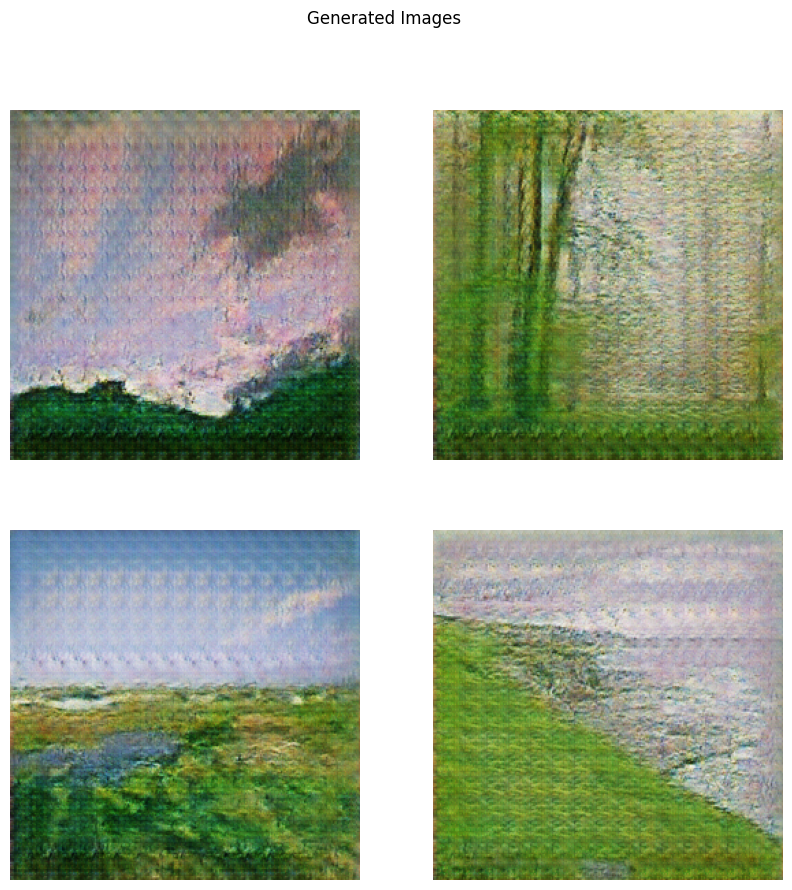

In [ ]:
# Example usage
generator_g = Generator()  # Load your generator model here
generator_g.load_weights('generator_g.h5')

# Generate and plot images
generate_and_plot_images(generator_g, photo_dataset)

### Save the generated images

In [ ]:
# Save the images
save_images(generator_g, photo_dataset, 'images.zip', num_images=10000)

## Conclusion

We observe that the generator's losses are not decreasing significantly, but the final result is still quite good. I believe this is mainly due to the inherent nature of the generator and discriminator, as they are updated simultaneously.

Additionally, due to the 5-hour time limit for this Kaggle competition, I had to reduce the number of epochs from 120 to 64, which takes almost the full 5 hours.

Below is the competition leaderboard and the corresponding scores.

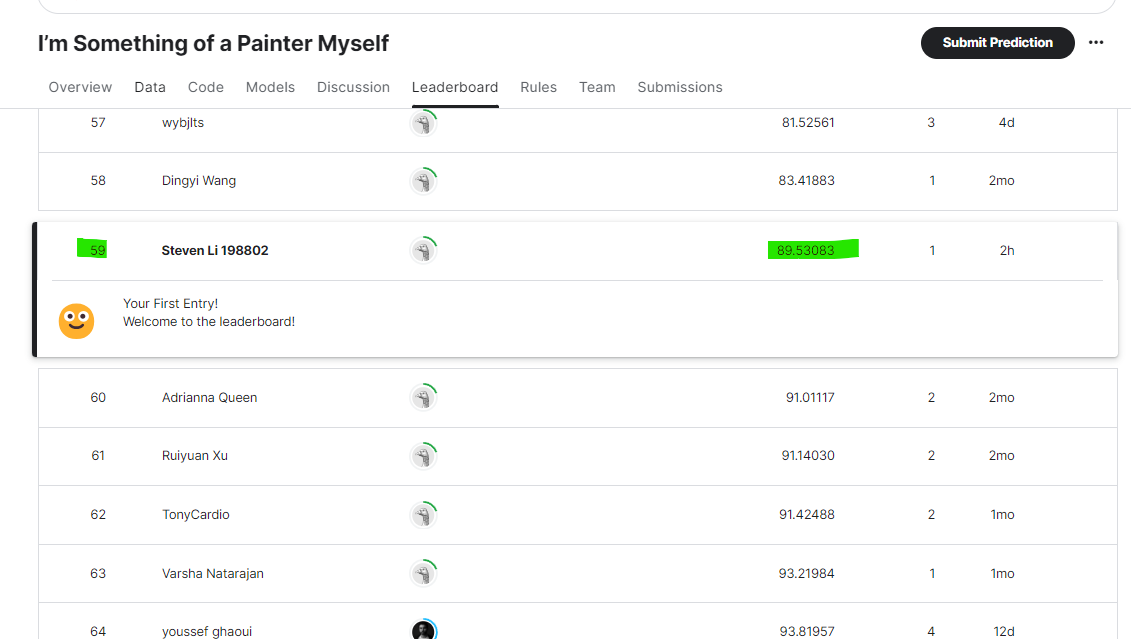